# BMMC Multi-scale Footprinting Vignette

Version 1 - 02/25/2023

## 1. Loading input data & packages for footprinting

In [1]:
from Footprinter import Footprinter

## 2. Initialize an footprinting Project

In [2]:
import pandas as pd
import numpy as np
barcodeGroups = pd.read_table("/home/rzhang/multiScaleFootprinting/data/BMMCTutorial/barcodeGrouping.txt", sep='\t')
groups = np.unique(barcodeGroups['group'])
barcodeGroups

,barcode,group
0,T128.R1.124.R2.026.R3.048.P1.02,1
1,T128.R1.037.R2.155.R3.075.P1.06,1
2,T128.R1.057.R2.043.R3.017.P1.03,1
3,T128.R1.001.R2.057.R3.120.P1.02,1
4,T128.R1.041.R2.077.R3.050.P1.08,1
...,...,...
4999995,T124.R1.109.R2.097.R3.143.P1.04,1000
4999996,T128.R1.069.R2.095.R3.157.P1.03,1000
4999997,T128.R1.065.R2.068.R3.190.P1.01,1000
4999998,T128.R1.059.R2.126.R3.101.P1.02,1000


In [3]:
project = Footprinter(
                 projectName="BMMCTutorial",
                 refGenome="hg38",
                 projectMainDir="/home/rzhang/multiScaleFootprinting/",
                 regions='/home/rzhang/multiScaleFootprinting/data/BMMCTutorial/BMMCTutorialRegions_py.bed',
                 barcodeGrouping=barcodeGroups,
                 groups=groups,
                 model_dir='/home/rzhang/multiScaleFootprinting/data',# directory with pretrained models
                 )

## getBias step is done when initializing projects

## 3. getCountTensor

In [4]:
project.computeCountTensor(
                        pathToFrags='/home/rzhang/multiScaleFootprinting/data/BMMCTutorial/BMMCTutorialFragments.tsv',  # Path or list of paths to fragments file
                       maxFragLength=None,  # Fragment length upper limit
                       saveName='chunkedCountTensor.h5',
                       nrows=np.Inf,  # Max number of rows when reading from fragments file
                       chunkSize=2000,  # Chunk size for parallel processing of regions (I want to remove this arg)
                       fragchunkSize=1000000,
                       nCores=16,  # Number of cores to use
                       returnCombined=False,
                       # Whether to return the combined result for all chunks. Set it to False when data is too big,
                       plus_shift=4,
                       minus_shift=-5)

extra_shift: p/m 0 0
Removing frags with length > None  bp
Processing file: BMMCTutorialFragments.tsv
submitting 0 jobs, takes: 0.21 s


 - Processing :   0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

## 4. getmultiScaleFootprints

In [5]:
project.getFootprints(
                modes=np.arange(2, 101), # int or list of int. This is used for retrieving the correct dispersion model.
                footprintRadius=None, # Radius of the footprint region
                flankRadius=None, # Radius of the flanking region (not including the footprint region)
                nCores = 16, # Number of cores to use
                saveName = "chunkedFootprintResults.h5",
                verbose=True,
                returnCombined=None,
                    )

identified region width:  1000


 - Footprinting!:   0%|          | 0/990 [00:00<?, ?it/s]

## 5. getTFBSscore

In [6]:
project.getBindingScore(
                        model = 'TF',
                        motifs=None,
                        contextRadius=100,  # well it's never ued in the R version... so... yeah
                        nCores=16,
                        saveName="chunkedBindingResults.h5",
                        returnCombined=None,
                        )

collecting Binding prediction:   0%|          | 0/10 [00:00<?, ?it/s]

## 6. Some interpretation of the generated results

In [7]:
import h5py

with h5py.File(project.FootPrintPath, "r") as f:
    print (f.keys())
    print ('group', np.array(f['group'].asstr())[:10])
    print ('regions', np.array(f['regions'].asstr())[:10])
    print ('scales', np.array(f['scales'])[:10])

<KeysViewHDF5 ['chr20:56358378-56359378', 'chr20:56360346-56361346', 'chr20:56362453-56363453', 'chr20:56372619-56373619', 'chr20:56373657-56374657', 'chr20:56376099-56377099', 'chr20:56391915-56392915', 'chr20:56399697-56400697', 'chr20:56409242-56410242', 'chr20:56411665-56412665', 'group', 'regions', 'scales']>
group ['1' '2' '3' '4' '5' '6' '7' '8' '9' '10']
regions ['chr20:56358378-56359378' 'chr20:56360346-56361346'
 'chr20:56362453-56363453' 'chr20:56372619-56373619'
 'chr20:56373657-56374657' 'chr20:56376099-56377099'
 'chr20:56391915-56392915' 'chr20:56399697-56400697'
 'chr20:56409242-56410242' 'chr20:56411665-56412665']
scales [ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]


You'll see that for the footprintresults hdf5 file, we have keys including 'group', 'regions', 'scales' which stores the description of these info. And the actual results are stored by keys named as the region_string. Let's go into one.

In [8]:
with h5py.File(project.FootPrintPath, "r") as f:
    results = f['chr20:56358378-56359378'][:]
print (results.shape)

(1000, 99, 1000)


The retrieved results have shape 1000 x 99 x 1000, which corresponds to (#groups, #scales, #positions).
Let's visualize one. 

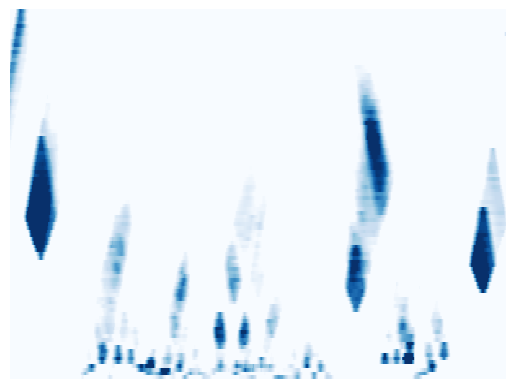

In [9]:
import seaborn as sns
# 0 -> first group; ::-1 -> turn it upside down for visualization (seaborn makes 0 on y axis to be the top)
# 100:-100, first 100 pixels and last 100 pixels are noisy, remove them
ax = sns.heatmap(results[0, ::-1, 100:-100], cmap='Blues', square=False, cbar=False,vmax=2, vmin=0.5)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

Now let's go into the TFBS scores

In [10]:
with h5py.File(project.BindingScorePath['TF'], "r") as f:
    print (f.keys())
    print ('group', np.array(f['group'].asstr())[:10])
    print ('regions', np.array(f['regions'].asstr())[:10])

<KeysViewHDF5 ['chr20:56358378-56359378', 'chr20:56360346-56361346', 'chr20:56362453-56363453', 'chr20:56372619-56373619', 'chr20:56373657-56374657', 'chr20:56376099-56377099', 'chr20:56391915-56392915', 'chr20:56399697-56400697', 'chr20:56409242-56410242', 'chr20:56411665-56412665', 'group', 'regions']>
group ['1' '2' '3' '4' '5' '6' '7' '8' '9' '10']
regions ['chr20:56358378-56359378' 'chr20:56360346-56361346'
 'chr20:56362453-56363453' 'chr20:56372619-56373619'
 'chr20:56373657-56374657' 'chr20:56376099-56377099'
 'chr20:56391915-56392915' 'chr20:56399697-56400697'
 'chr20:56409242-56410242' 'chr20:56411665-56412665']


Very similar structure... Let's get into one.

In [11]:
with h5py.File(project.BindingScorePath['TF'], "r") as f:
    results = f['chr20:56358378-56359378']
    print (results.keys())
    results = np.array(results['BindingScore'])
print (results.shape)

<KeysViewHDF5 ['BindingScore']>
(1000, 80)


The retrieved results have shape 1000 x 80 , which corresponds to (#groups, #sites). Let's visualize one.

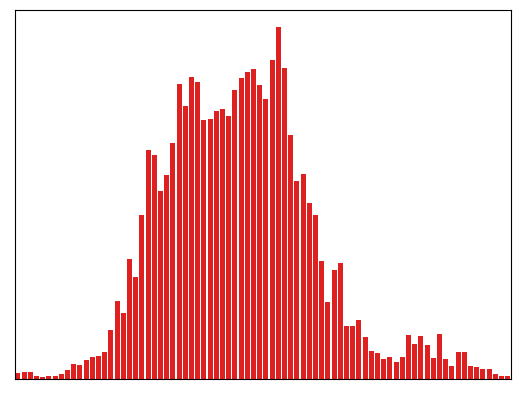

In [12]:
ax = sns.barplot(x=np.arange(results[0].shape[0]), y=results[0], color='red')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)